In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision.models as models
from keras.datasets import mnist
from PIL import Image

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None, target_transform=None):
        self.img_labels = pd.read.csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label 

In [3]:
training_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

labels_map = { 
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",}

from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size = 128, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 128, shuffle = True)

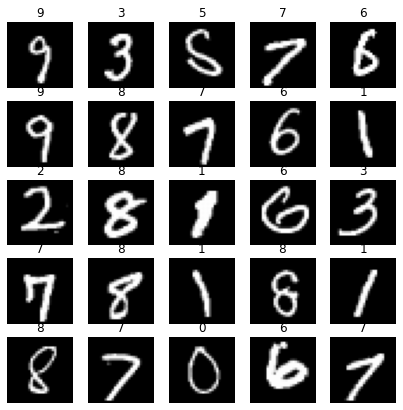

In [4]:
figure = plt.figure(figsize= (7,7))
cols, rows = 5, 5
for i in range(1, cols*rows +1):
    sample_idx = torch.randint(len(training_data), size = (1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


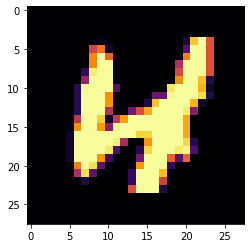

Label: 4


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = "inferno")
plt.show()
print(f"Label: {label}")

In [6]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
    
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 5
for i in range(epochs):
    print(f"Epoch {i+1}\n---------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
---------------------------------
loss: 2.308757 [    0/60000]
loss: 0.752669 [12800/60000]
loss: 0.254233 [25600/60000]
loss: 0.445842 [38400/60000]
loss: 0.390019 [51200/60000]
Test Error: 
 Accuracy: 91.3%, Avg loss: 0.293704 

Epoch 2
---------------------------------
loss: 0.233669 [    0/60000]
loss: 0.220185 [12800/60000]
loss: 0.185942 [25600/60000]
loss: 0.401706 [38400/60000]
loss: 0.223466 [51200/60000]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.213687 

Epoch 3
---------------------------------
loss: 0.171897 [    0/60000]
loss: 0.281473 [12800/60000]
loss: 0.198691 [25600/60000]
loss: 0.240821 [38400/60000]
loss: 0.162085 [51200/60000]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.168694 

Epoch 4
---------------------------------
loss: 0.275965 [    0/60000]
loss: 0.079271 [12800/60000]
loss: 0.172542 [25600/60000]
loss: 0.168276 [38400/60000]
loss: 0.065289 [51200/60000]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.141485 

Epoch 5
---------------------------------
lo

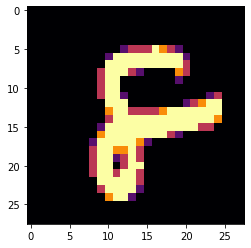

Label: 8


In [13]:
img = train_features[2].squeeze()
label = train_labels[2]
plt.imshow(img, cmap = "inferno")
plt.show()
print(f"Label: {label}")

In [14]:
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x.cuda())
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"


In [15]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [16]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [17]:
img = train_X[0]
convert_tensor = transforms.ToTensor()
convert_tensor(img)


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [18]:
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

model.eval()
x = convert_tensor(img1)
with torch.no_grad():
    pred = model(x.cuda())
    predicted = classes[pred[0].argmax(0)]
    print(f'Predicted: "{predicted}"')

NameError: name 'img1' is not defined

In [ ]:
plt.imshow(test_X[2], cmap = "jet")

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model.load_state_dict(torch.load("Y:\Python\Tasks\model.pth"))